In [1]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [ ]:
# load trained network
model = load_model('saved_models/R0_sampleRate_migrationRate')

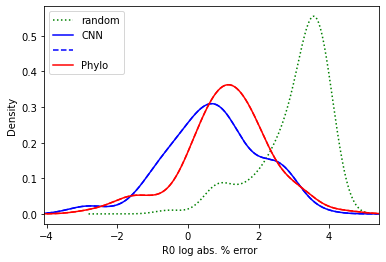

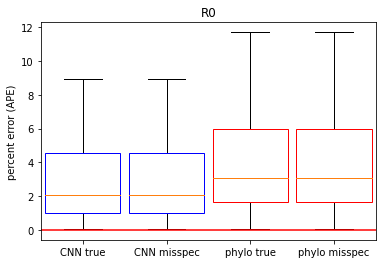

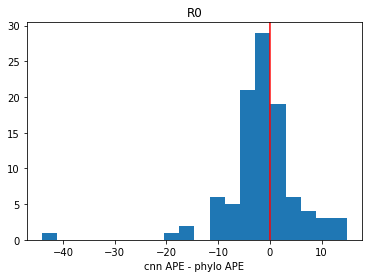

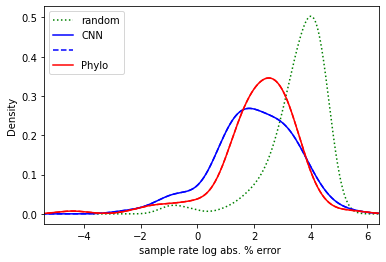

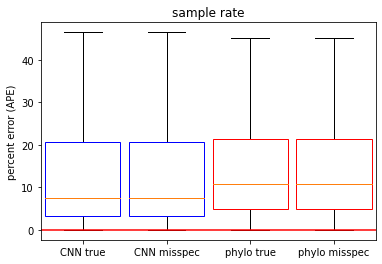

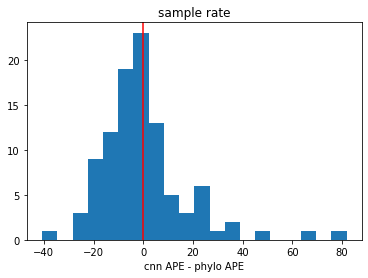

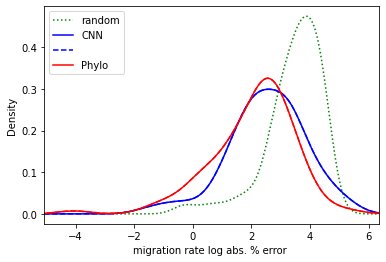

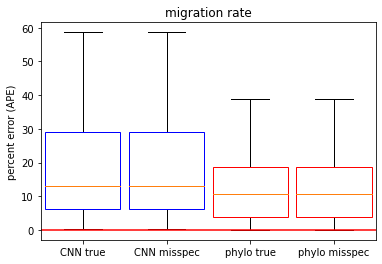

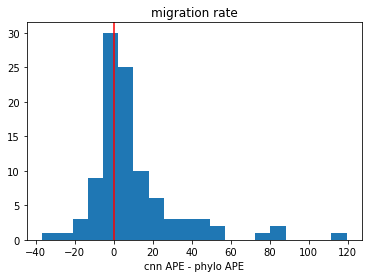

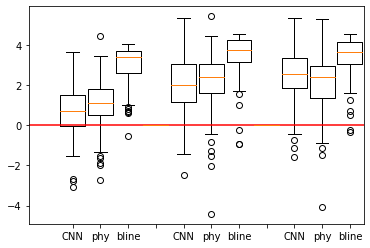

In [20]:
########################################
# comapre APE of CNN to that of phylo ##
########################################
# revbayes output
phylo_post = pd.read_table("data_files/phylo_estimates_files/true_model_3params_R0_delta_migr.postmeans", 
                   header = None, index_col = 0, error_bad_lines = False).to_numpy()
phylo_labels = phylo_comparison_labels[:,5:8]

phylo_post_ape = 100 * np.abs((phylo_labels - phylo_post)/phylo_labels)

## cnn predictions for trees analyzed by revbayes

phylocomp_subsample_prop = phylo_comparison_data[:,(max_tips-1) * 7]
phylcomp_mu = phylo_comparison_data[:,(max_tips - 3) * 7]
phylocomp_num_tips = cn.get_num_tips(phylo_comparison_data)

# gather auxilliary prior data
aux_phylocomp = np.vstack((phylcomp_mu, phylocomp_subsample_prop, phylocomp_num_tips,
                          phylo_comparison_labels[:,8], phylo_comparison_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))

norm_phylo_comparison_data = cn.normalize(phylo_comparison_data, (train_mean, train_sd))


# create input tensors
phylocomp_treeLocation_tensor, phylocomp_prior_tensor = cn.dev_create_data_tensors(data = norm_phylo_comparison_data, 
                                                                                   mu = norm_aux_phylocomp[:,0],
                                                                            subsample_prop = norm_aux_phylocomp[:,1],
                                                                            num_tips = norm_aux_phylocomp[:,2],
                                                                            tmrca = norm_aux_phylocomp[:,3],
                                                                            mean_bl = norm_aux_phylocomp[:,4],
                                                                            num_locs = num_locs,
                                                                            max_tips = max_tips,
                                                                            cblv_contains_mu_rho = True)

phylocomp_normalized_preds = mymodel.predict([phylocomp_treeLocation_tensor, phylocomp_prior_tensor])

# reversing normalization
# cnn_phylocomp_preds = np.array([ np.add(np.multiply(phylocomp_normalized_preds[:,i-5], label_sd[i]), label_means[i]) for i in range(5,8)]).transpose()
cnn_phylocomp_preds = cn.denormalize(phylocomp_normalized_preds, train_label_means, train_label_sd)
cnn_phylocomp_ape = 100 * np.abs((cnn_phylocomp_preds - phylo_comparison_labels[:,5:8])/phylo_comparison_labels[:,5:8])

mean_bl_R0 = 2 + (8 - 2)/2
mean_bl_delta = 0.0001 + (0.005 - 0.0001)/2
mean_bl_migration = 0.0001 + (0.005 - 0.0001)/2
mean_bl_R0_ape = 100 * np.abs(phylo_labels[:, 0] - mean_bl_R0)/mean_bl_R0
mean_bl_sample_ape = 100 * np.abs(phylo_labels[:, 1] - mean_bl_delta)/mean_bl_delta
mean_bl_migration_ape = 100 * np.abs(phylo_labels[:, 2] - mean_bl_migration)/mean_bl_migration
baseline_ape = np.column_stack((mean_bl_R0_ape, mean_bl_sample_ape, mean_bl_migration_ape))



cn.make_experiment_density_plots(cnn_phylocomp_ape, phylo_post_ape,
                       cnn_phylocomp_ape, phylo_post_ape, baseline_ape,
                          plot_legend = ["random", "CNN", "", "Phylo", ])


plt.boxplot([np.log(cnn_phylocomp_ape[:,0]), np.log(phylo_post_ape[:,0]), np.log(baseline_ape[:,0]), 0,
            np.log(cnn_phylocomp_ape[:,1]), np.log(phylo_post_ape[:,1]), np.log(baseline_ape[:,1]), 0,
            np.log(cnn_phylocomp_ape[:,2]), np.log(phylo_post_ape[:,2]), np.log(baseline_ape[:,2])],
           widths=0.9,
            labels = ["CNN", "phy", "bline", "",
                     "CNN", "phy", "bline", "",
                     "CNN", "phy", "bline"])
plt.axline((0,0),slope=0,color="red")
plt.show()


In [21]:
# cn.plot_preds_labels(cnn_phylocomp_preds, phylo_post, axis_labels = ["cnn", "phylo"]
# cn.plot_preds_labels((cnn_phylocomp_preds-phylo_labels), 
#                      (phylo_post-phylo_labels), axis_labels = ["cnn", "phylo"])
# cn.plot_preds_labels(np.log(cnn_phylocomp_ape), np.log(phylo_post_ape), axis_labels = ['CNN APE', 'phylo APE'])

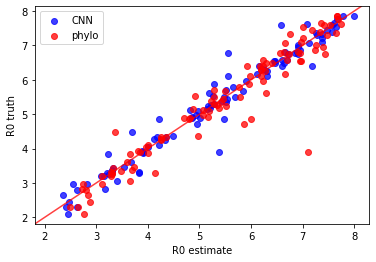

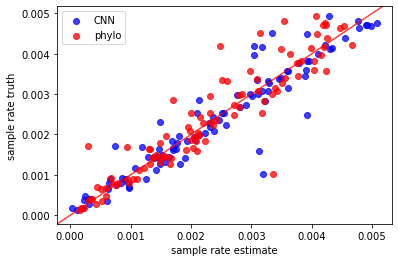

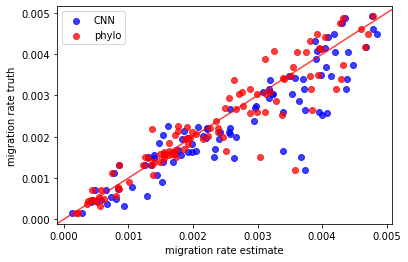

In [22]:
cn.plot_overlaid_scatter(cnn_phylocomp_preds, phylo_post,
                         phylo_comparison_labels[:,5:8], 
                         param_names = ["R0", "sample rate", "migration rate"])


In [37]:
# print percent absolute error medians

# look into wasserstein distances from baseline: scipy.stats.wasserstein_distance()

print("R0")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,0] - phylo_post_ape[:,0]))
print(np.median(phylo_post_ape[:,0]), np.quantile(phylo_post_ape[:,0], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,0]), np.quantile(cnn_phylocomp_ape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
# bins = np.arange(1,10, step = 0.5)[0]
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,0], bins=bins),  np.histogram(mean_bl_R0_ape, bins=bins))/ 
#                        sp.entropy(np.histogram(phylo_post_ape[:,0], np.histogram(mean_bl_R0_ape)))
print("delta")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,1] - phylo_post_ape[:,1]))
print(np.median(phylo_post_ape[:,1]), np.quantile(phylo_post_ape[:,1], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,1]), np.quantile(cnn_phylocomp_ape[:,1], [0.025, 0.975]))
print(np.median(baseline_ape[:,1]), np.quantile(baseline_ape[:,1], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins) ) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,1], bins=bins), np.histogram(mean_bl_sample_ape, bins=bins))))
print("migration")
print("mean difference in APE (CNN_APE - Phylo_APE): ",  np.mean(cnn_phylocomp_ape[:,2] - phylo_post_ape[:,2]))
print(np.median(phylo_post_ape[:,2]), np.quantile(phylo_post_ape[:,2], [0.025, 0.975]))
print(np.median(cnn_phylocomp_ape[:,2]), np.quantile(cnn_phylocomp_ape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))
# print("  KL ratio: ", (sp.entropy(np.histogram(cnn_phylocomp_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins)) / 
#                        sp.entropy(np.histogram(phylo_post_ape[:,2], bins=bins), np.histogram(mean_bl_migration_ape, bins=bins))))

# cn.plot_preds_labels(phylo_post, phylo_labels)
# cn.plot_preds_labels(cnn_phylocomp_preds, phylo_labels)


R0
mean difference in APE (CNN_APE - Phylo_APE):  -0.5266937009041822
3.0898447948912695 [ 0.16928646 25.59259591]
2.257936864256693 [ 0.08033737 31.37461105]
29.7691 [ 1.99614  56.117725]
delta
mean difference in APE (CNN_APE - Phylo_APE):  2.6884483923262996
10.871104082282795 [ 0.24279179 51.80618819]
7.165689371666804 [  0.12482351 105.14738507]
43.13725490196078 [ 1.71568627 93.14705882]
migration
mean difference in APE (CNN_APE - Phylo_APE):  5.907759563967992
10.786720092468759 [ 0.3674628  61.60586594]
11.709135326485494 [ 0.70803745 99.43087467]
37.54939215686275 [ 1.86304706 91.97673725]


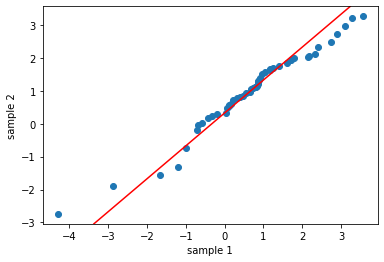

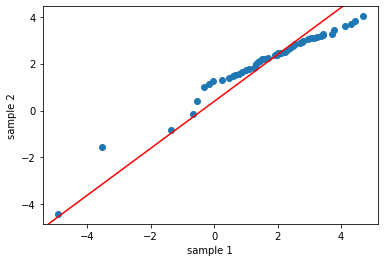

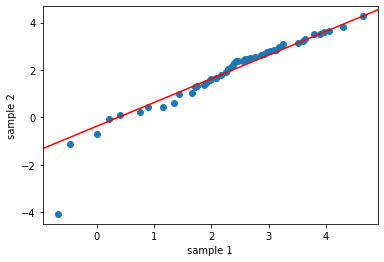

[None, None, None]

In [38]:
[cn.qq_plot(np.log(cnn_phylocomp_ape[:,i]), np.log(phylo_post_ape[:,i]), num_quantiles = 50) for i in range(0,3)]
# [cn.qq_plot(cnn_phylocomp_ape[:,i], phylo_post_ape[:,i], num_quantiles = 50) for i in range(0,3)]
# [cn.qq_plot(cnn_phylocomp_preds[:,i] - phylo_labels[:,i], phylo_post[:,i] - phylo_labels[:,i], num_quantiles = 50) for i in range(0,3)]

In [144]:
#########################################
# sample rate misspecified model trees ##
#########################################
misspec_delta_data = pd.read_csv("data_files/cblv_files/misspec_delta.cblv.csv", 
                   header =None, error_bad_lines = False).to_numpy()
# load labels data
misspec_delta_labels = pd.read_csv("data_files/label_files/alt_loc_R0_delta_migration_treelength_meanbl_misspec_delta.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [145]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
norm_misspec_delta_tree_length = (misspec_delta_labels[:,8]-label_means[8])/label_sd[8]
norm_misspec_delta_mean_branch_length = (misspec_delta_labels[:,9]-label_means[9])/label_sd[9]
norm_misspec_delta_num_tips = (cn.get_num_tips(misspec_delta_data) - mean_num_tips) / sd_num_tips

misspec_treeLocation_tensor, misspec_prior_tensor = cn.create_data_tensors(misspec_delta_data,
                                                                           norm_misspec_delta_tree_length,
                                                                           norm_misspec_delta_mean_branch_length,
                                                                           norm_misspec_delta_num_tips,
                                                                           normalize_tree_stats = False)

In [146]:
# predict
miss_normalized_preds = mymodel.predict([misspec_treeLocation_tensor, 
                                         misspec_prior_tensor])

# denormalize
miss_denormalized_test_labels = misspec_delta_labels[:,5:8]

# preds use label means and sd from training data normalization
miss_denormalized_preds = np.array([ np.add(np.multiply(miss_normalized_preds[:,i-5], label_sd[i]), 
                                            label_means[i]) for i in range(5,8)]).transpose()

# measure error
miss_abserror = np.abs(np.subtract(miss_denormalized_preds, miss_denormalized_test_labels))
miss_mape = np.multiply(100, np.abs(np.divide(miss_abserror, miss_denormalized_test_labels)))


In [147]:
im.reload(cn)

<module 'cnn_utilities' from 'C:\\Users\\ammon_work\\Desktop\\git_repos\\epi_geo_simulation\\neural_network_dev\\cnn_utilities.py'>

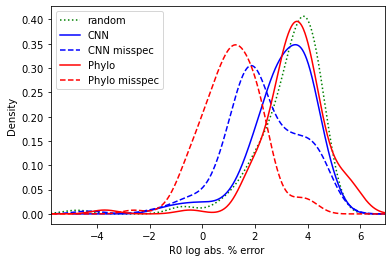

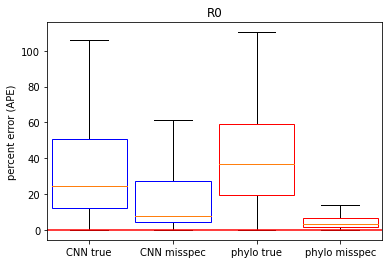

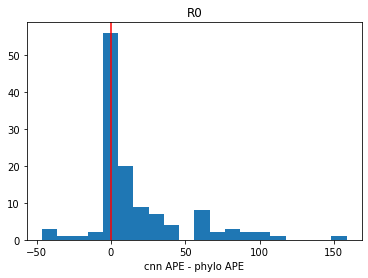

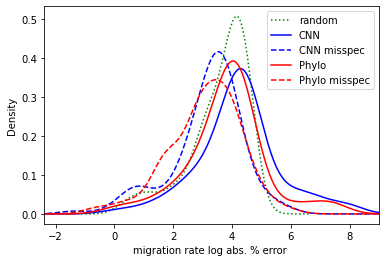

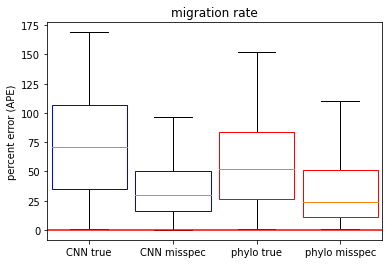

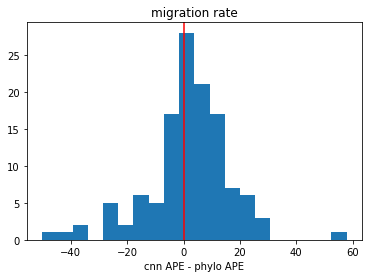

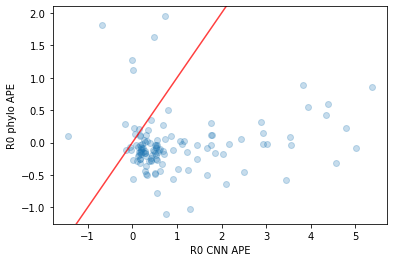

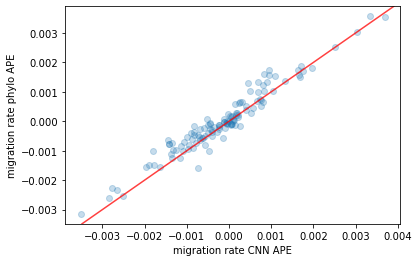

CNN R0:  45.499487687687264
phylo R0:  -21.83773139691791


In [148]:
# phylo mean prediction file
miss_phylo_post_mean = pd.read_table("data_files/phylo_estimates_files/sample_misspec_3params_R0_delta_migr.postmeans", 
                                    index_col=0, header = None).to_numpy()

# compute absolute percent error
miss_phylo_abserror = np.abs(np.subtract(miss_phylo_post_mean, miss_denormalized_test_labels))
miss_phylo_mape = np.multiply(100, np.abs(np.divide(miss_phylo_abserror, miss_denormalized_test_labels)))


# plot

cn.make_experiment_density_plots(cnn_phylocomp_ape[:,[0,2]], phylo_post_ape[:,[0,2]],
                       miss_mape[:,[0,2]], miss_phylo_mape[:,[0,2]], baseline_ape[:,[0,2]],
                                xlabel = ["R0", "migration rate"])

cn.plot_preds_labels((miss_denormalized_preds[:,[0,2]] - miss_denormalized_test_labels[:,[0,2]]), 
                     (miss_phylo_post_mean[:,[0,2]] - miss_denormalized_test_labels[:,[0,2]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN APE', 'phylo APE'])

print("CNN R0: " , np.median(cnn_phylocomp_ape) - np.median(miss_mape[:,0]))
print("phylo R0: " , np.median(miss_phylo_mape) - np.median(phylo_post_ape[:,0]))

In [149]:
print("CNN R0: " , (np.median(miss_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN m rate: " , (np.median(miss_mape[:,2]) - np.median(cnn_phylocomp_ape[:,2])))
print("phylo m rate: " , (np.median(miss_phylo_mape[:,2]) - np.median(phylo_post_ape[:,2])))



CNN R0:  -16.71407186328319
phylo R0:  -33.42934548384809
CNN m rate:  -41.49095537835545
phylo m rate:  -27.608316858739705


In [150]:

print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,0] - miss_phylo_mape[:,0]))
print(np.median(miss_phylo_mape[:,0]), np.quantile(miss_phylo_mape[:,0], [0.025, 0.975]))
print(np.median(miss_mape[:,0]), np.quantile(miss_mape[:,0], [0.025, 0.975]))
print(np.median(baseline_ape[:,0]), np.quantile(baseline_ape[:,0], [0.025, 0.975]))
print("migration")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_mape[:,2] - miss_phylo_mape[:,2]))
print(np.median(miss_phylo_mape[:,2]), np.quantile(miss_phylo_mape[:,2], [0.025, 0.975]))
print(np.median(miss_mape[:,2]), np.quantile(miss_mape[:,2], [0.025, 0.975]))
print(np.median(baseline_ape[:,2]), np.quantile(baseline_ape[:,2], [0.025, 0.975]))



R0
median difference in APE (CNN_APE - Phylo_APE):  4.68001176529218
3.170950152673152 [ 0.44071991 35.47985639]
8.005306795043683 [  0.48231922 104.132198  ]
36.5522 [ 1.21767  95.334055]
migration
median difference in APE (CNN_APE - Phylo_APE):  2.4934425714890485
24.062751247158992 [  1.26908995 152.73505852]
29.7829723634582 [  1.45125655 175.08165857]
48.64070588235295 [ 2.34053039 92.85456078]


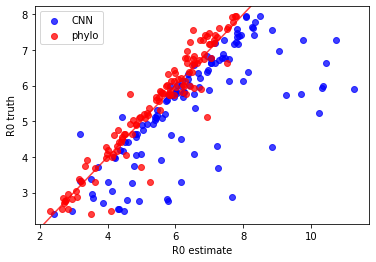

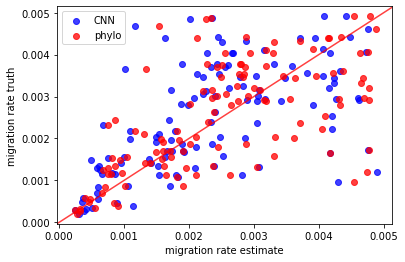

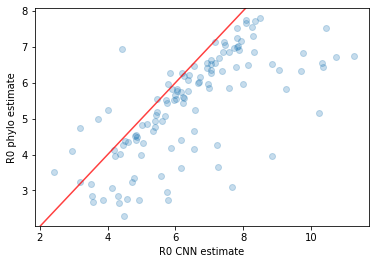

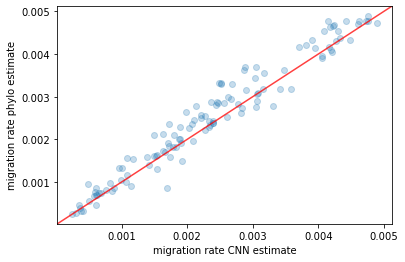

In [151]:
cn.plot_overlaid_scatter(miss_denormalized_preds[:,[0,2]], miss_phylo_post_mean[:,[0,2]],
                         miss_denormalized_test_labels[:,[0,2]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((miss_denormalized_preds[:,[0,2]]), 
                     (miss_phylo_post_mean[:,[0,2]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [152]:
################################
# misspecified migration rate ##
################################
misspec_migration_data = pd.read_csv("data_files/cblv_files/misspec_migration.cblv.csv", 
                   header =None, error_bad_lines = False).to_numpy()
# load labels data
misspec_migration_labels = pd.read_csv("data_files/label_files/alt_loc_R0_delta_migration_treelength_meanbl_misspec_migration.csv",
                    header = None, error_bad_lines = False, index_col = None).to_numpy()


In [153]:
#########################
# prepare input tensors #
#########################

# normalize with training means and sds
norm_misspec_migration_tree_length = (misspec_migration_labels[:,8]-label_means[8])/label_sd[8]
norm_misspec_migration_mean_branch_length = (misspec_migration_labels[:,9]-label_means[9])/label_sd[9]
norm_misspec_migration_num_tips = (cn.get_num_tips(misspec_migration_data) - mean_num_tips) / sd_num_tips

misspec_migration_treeLocation_tensor, misspec_migration_prior_tensor = cn.create_data_tensors(misspec_migration_data,
                                                                           norm_misspec_migration_tree_length,
                                                                           norm_misspec_migration_mean_branch_length,
                                                                           norm_misspec_migration_num_tips,
                                                                           normalize_tree_stats = False)


# normalize labels # this isn't necessary. Fix
miss_migration_label_means = misspec_migration_labels.mean(axis=0)
miss_migration_label_sd = misspec_migration_labels.std(axis=0)
misspec_migration_norm_labels = np.subtract(misspec_migration_labels, miss_migration_label_means)
misspec_migration_norm_labels = np.divide(misspec_migration_norm_labels, miss_migration_label_sd)


In [154]:
# predict
miss_migration_normalized_preds = mymodel.predict([misspec_migration_treeLocation_tensor, 
                                         misspec_migration_prior_tensor])

# denormalize
miss_migration_denormalized_test_labels = np.array([ np.add(np.multiply(misspec_migration_norm_labels[:,i], miss_migration_label_sd[i]), 
                                                  miss_migration_label_means[i]) for i in range(5,8)]).transpose()
# preds use label means and sd from training data normalization
miss_migration_denormalized_preds = np.array([ np.add(np.multiply(miss_migration_normalized_preds[:,i-5], label_sd[i]), 
                                            label_means[i]) for i in range(5,8)]).transpose()

# measure error
miss_migration_abserror = np.abs(np.subtract(miss_migration_denormalized_preds, miss_migration_denormalized_test_labels))
miss_migration_mape = np.multiply(100, np.abs(np.divide(miss_migration_abserror, miss_migration_denormalized_test_labels)))



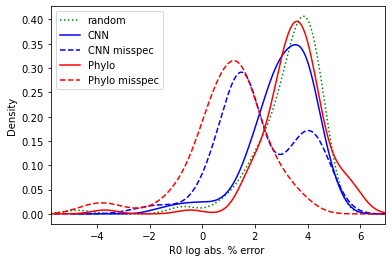

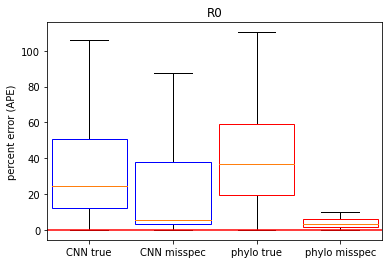

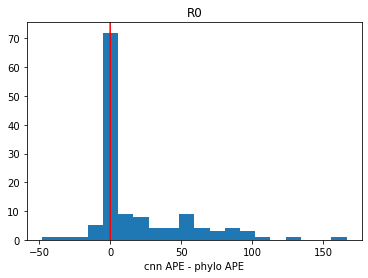

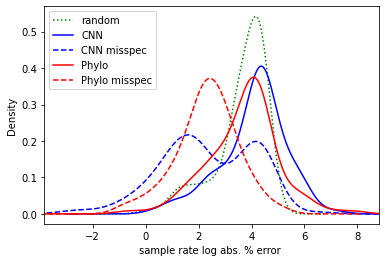

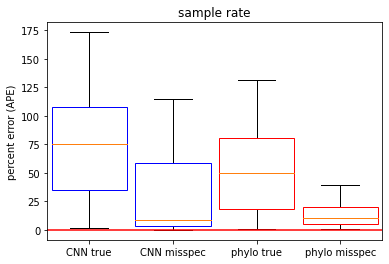

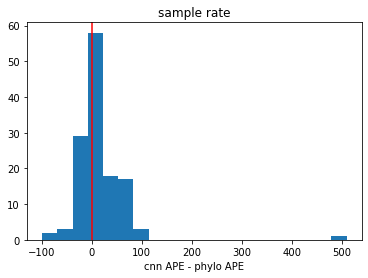

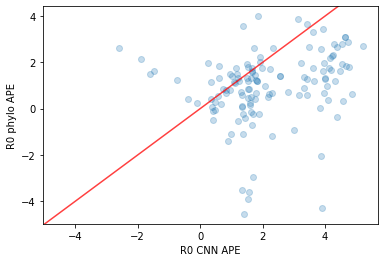

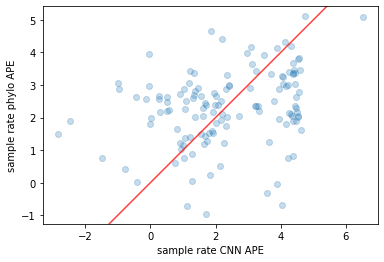

R0
median difference in APE (CNN_APE - Phylo_APE):  3.5812393121730377
sample rate
median difference in APE (CNN_APE - Phylo_APE):  0.5887180725498045


In [155]:
# phylo mean prediction file
miss_migration_phylo_post_mean = pd.read_table("data_files/phylo_estimates_files/misspec_migration_R0_delta_migration.postmeans",
                                              index_col=0, header = None).to_numpy()
# compute absolute percent error
miss_migration_phylo_abserror = np.abs(np.subtract(miss_migration_phylo_post_mean, 
                                                   miss_migration_denormalized_test_labels))
miss_migration_phylo_mape = np.multiply(100, np.abs(np.divide(miss_migration_phylo_abserror, 
                                                              miss_migration_denormalized_test_labels)))


# plot
cn.make_experiment_density_plots(cnn_phylocomp_ape[:,[0,1]], phylo_post_ape[:,[0,1]],
                       miss_migration_mape[:,[0,1]], miss_migration_phylo_mape[:,[0,1]],
                           baseline_ape[:,[0,1]],
                                xlabel = ["R0", "sample rate"])

# correlation in error?
cn.plot_preds_labels(np.log(miss_migration_mape[:,[0,1]]), np.log(miss_migration_phylo_mape[:,[0,1]]), 
                     param_names = ["R0", "sample rate"], axis_labels = ['CNN APE', 'phylo APE'])

# summary
print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,0] - miss_migration_phylo_mape[:,0]))


print("sample rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(miss_migration_mape[:,1] - miss_migration_phylo_mape[:,1]))


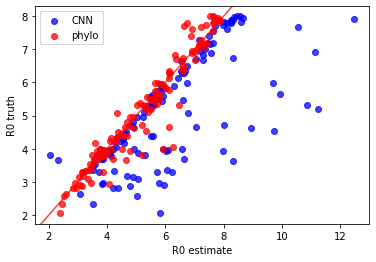

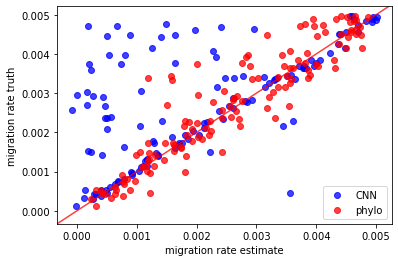

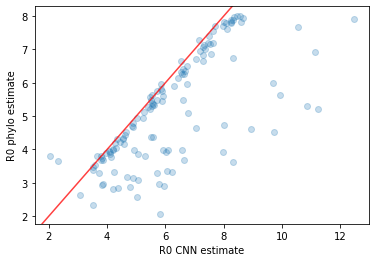

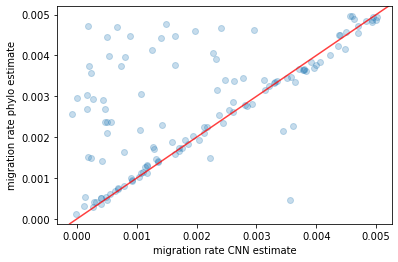

In [156]:
cn.plot_overlaid_scatter(miss_migration_denormalized_preds[:,[0,1]], miss_migration_phylo_post_mean[:,[0,1]],
                         misspec_migration_labels[:,[5,6]], 
                         param_names = ["R0", "migration rate"])

cn.plot_preds_labels((miss_migration_denormalized_preds[:,[0,1]]), 
                     (misspec_migration_labels[:,[5,6]]), 
                     param_names = ["R0", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [157]:
print("CNN R0: " , (np.median(miss_migration_mape[:,0]) - np.median(cnn_phylocomp_ape[:,0])))
print("phylo R0: " , (np.median(miss_migration_phylo_mape[:,0]) - np.median(phylo_post_ape[:,0])))

print("CNN sample rate: " , (np.median(miss_migration_mape[:,1]) - np.median(cnn_phylocomp_ape[:,1])))
print("phylo sample rate: " , (np.median(miss_migration_phylo_mape[:,1]) - np.median(phylo_post_ape[:,1])))



CNN R0:  -18.936423099432126
phylo R0:  -33.31106025527617
CNN sample rate:  -66.38212716810527
phylo sample rate:  -39.49678735632182


In [158]:
#######################
## misspecified tree ##
#######################
# read cblv data
misspec_tree_cblv = pd.read_csv("data_files/cblv_files/misspec_phylogeny_treescale0.001.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()
true_tree_cblv = pd.read_csv("data_files/cblv_files/true_phylogeny_treescale0.001.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()

# read phylo data
misspec_tree_phylo = pd.read_table("data_files/phylo_estimates_files/misspec_phylo_scale0.001_misspectree_3params_R0_delta_migr.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()
true_tree_phylo = pd.read_table("data_files/phylo_estimates_files/misspec_phylo_scale0.001_truetree_3params_R0_delta_migr.postmeans",
                    header = None, error_bad_lines = False, index_col = 0).to_numpy()

# tree distances data
tree_overlap = pd.read_table("data_files/phylo_estimates_files/proportion_branches_shared_scale0.001.txt",
                            header = None).to_numpy()


# read labels
misspec_tree_param_labels = pd.read_csv("data_files/label_files/loc_R0_delta_migration_treelength_meanbl_misspec_tree_scale0.001.csv",
                    header = None, error_bad_lines = False).to_numpy()
true_tree_param_labels = pd.read_csv("data_files/label_files/loc_R0_delta_migration_treelength_meanbl_true_tree_scale0.001.csv",
                    header = None, error_bad_lines = False).to_numpy()


In [159]:
# prepare input data

norm_misspectree_tree_length = (misspec_tree_param_labels[:,8] - label_means[8])/label_sd[8]
norm_misspectree_mean_branch_length = (misspec_tree_param_labels[:,9] - label_means[9])/label_sd[9]
norm_misspectree_num_tips = (cn.get_num_tips(misspec_tree_cblv) - mean_num_tips) / sd_num_tips

misspectree_treeLocation_tensor, misspectree_prior_tensor = cn.create_data_tensors(misspec_tree_cblv, 
                                                                                   norm_misspectree_tree_length,
                                                                                   norm_misspectree_mean_branch_length,
                                                                                   norm_misspectree_num_tips,
                                                                                   normalize_tree_stats = False)


norm_truetree_tree_length = (true_tree_param_labels[:,8] - label_means[8])/label_sd[8]
norm_truepectree_mean_branch_length = (true_tree_param_labels[:,9] - label_means[9])/label_sd[9]
norm_truepectree_num_tips = (cn.get_num_tips(true_tree_cblv) - mean_num_tips) / sd_num_tips

truetree_treeLocation_tensor, truetree_prior_tensor = cn.create_data_tensors(true_tree_cblv, 
                                                                             norm_truetree_tree_length,
                                                                             norm_truepectree_mean_branch_length,
                                                                             norm_truepectree_num_tips,
                                                                             normalize_tree_stats = False)

# predict
normed_misspec_tree_preds = mymodel.predict([misspectree_treeLocation_tensor, misspectree_prior_tensor])
normed_true_tree_preds = mymodel.predict([truetree_treeLocation_tensor, truetree_prior_tensor])

# denormalize predictions
misspec_tree_preds = np.array([ np.add(np.multiply(normed_misspec_tree_preds[:,i-5], label_sd[i]), 
                                                  label_means[i]) for i in range(5,8)]).transpose()
true_tree_preds = np.array([ np.add(np.multiply(normed_true_tree_preds[:,i-5], label_sd[i]), 
                                                  label_means[i]) for i in range(5,8)]).transpose()




In [160]:
# cn.plot_preds_labels(true_tree_preds, true_tree_param_labels[:,5:8], 
#                      param_names = ["R0", "sample rate", "migration rate"])
# cn.plot_preds_labels(true_tree_phylo, true_tree_param_labels[:,5:8], 
#                      param_names = ["R0", "sample rate", "migration rate"])


# cn.plot_preds_labels(true_tree_preds, misspec_tree_preds, 
#                      param_names = ["R0", "sample rate", "migration rate"])
# cn.plot_preds_labels(true_tree_phylo, misspec_tree_phylo, 
#                      param_names = ["R0", "sample rate", "migration rate"])


In [161]:
# cnn prediction error
misstree_pred_abserror = np.abs(np.subtract(misspec_tree_preds, misspec_tree_param_labels[:,5:8]))
truetree_pred_abserror = np.abs(np.subtract(true_tree_preds, true_tree_param_labels[:,5:8]))

misstree_pred_mape = np.multiply(100, np.abs(np.divide(misstree_pred_abserror, misspec_tree_param_labels[:,5:8])))
truetree_pred_mape = np.multiply(100, np.abs(np.divide(truetree_pred_abserror, true_tree_param_labels[:,5:8])))

# phylo inference error
misstree_phylo_abserror = np.abs(np.subtract(misspec_tree_phylo, misspec_tree_param_labels[:,5:8]))
truetree_phylo_abserror = np.abs(np.subtract(true_tree_phylo, true_tree_param_labels[:,5:8]))

misstree_phylo_mape = np.multiply(100, np.abs(np.divide(misstree_phylo_abserror, misspec_tree_param_labels[:,5:8])))
truetree_phylo_mape = np.multiply(100, np.abs(np.divide(truetree_phylo_abserror, true_tree_param_labels[:,5:8])))

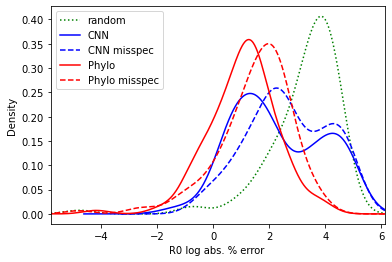

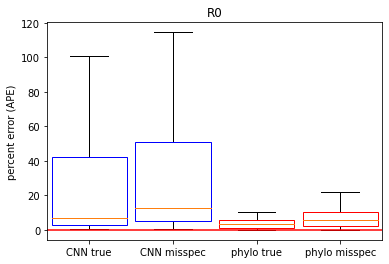

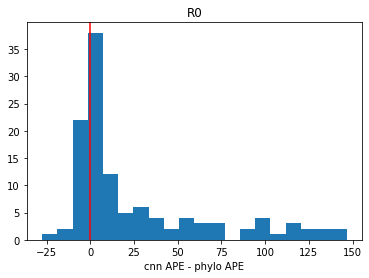

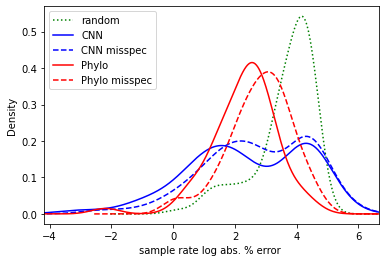

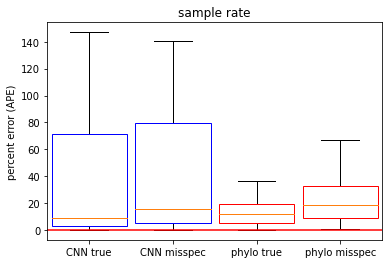

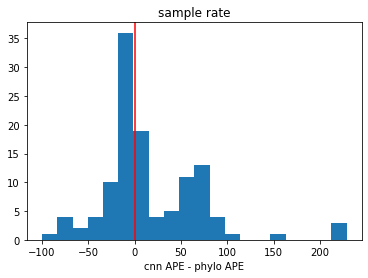

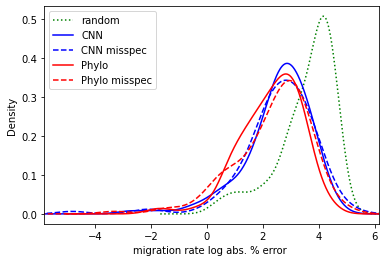

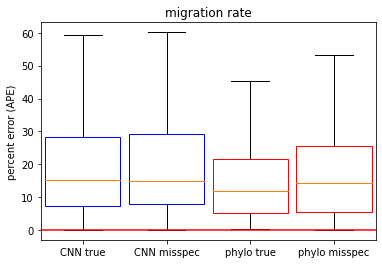

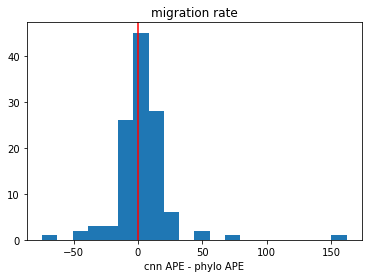

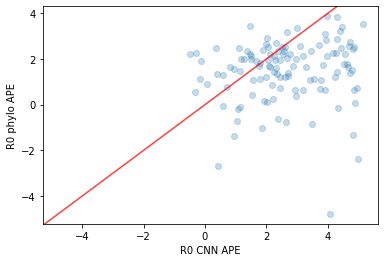

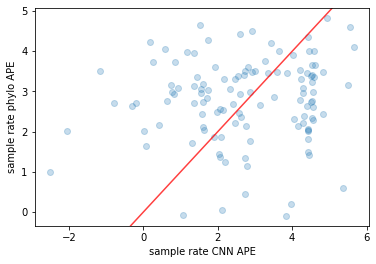

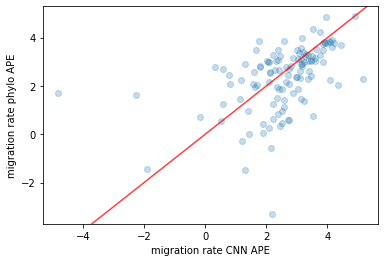

R0
median difference in APE (CNN_APE - Phylo_APE):  3.4802531976438726
median difference in APE (CNN_APE - Phylo_APE):  6.517565002985995
sample rate
median difference in APE (CNN_APE - Phylo_APE):  0.7075005186933845
median difference in APE (CNN_APE - Phylo_APE):  17.081761059585155
migration rate
median difference in APE (CNN_APE - Phylo_APE):  3.5327384044680183
median difference in APE (CNN_APE - Phylo_APE):  3.9264102133329444


In [162]:
# overlay density plots of reference and treatment group errors
cn.make_experiment_density_plots(truetree_pred_mape, truetree_phylo_mape,
                       misstree_pred_mape, misstree_phylo_mape,
                           baseline_ape)



cn.plot_preds_labels(np.log(misstree_pred_mape), np.log(misstree_phylo_mape), axis_labels = ['CNN APE', 'phylo APE'])

# R0
print("R0")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,0] - truetree_phylo_mape[:,0]))

print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(misstree_pred_mape[:,0] - misstree_phylo_mape[:,0]))

#  sample rate 
print("sample rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,1] - truetree_phylo_mape[:,1]))

print("median difference in APE (CNN_APE - Phylo_APE): ",  np.mean(misstree_pred_mape[:,1] - misstree_phylo_mape[:,1]))

#  migration rate 
print("migration rate")
print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(truetree_pred_mape[:,2] - truetree_phylo_mape[:,2]))

print("median difference in APE (CNN_APE - Phylo_APE): ",  np.median(misstree_pred_mape[:,2] - misstree_phylo_mape[:,2]))



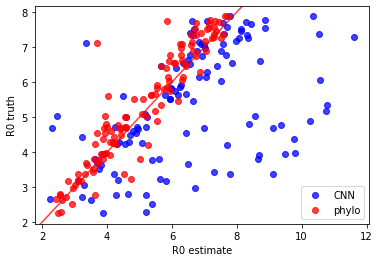

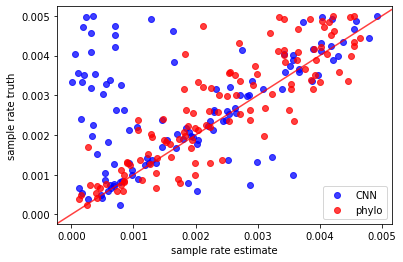

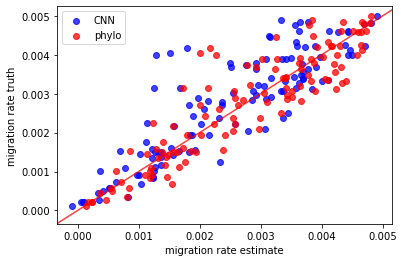

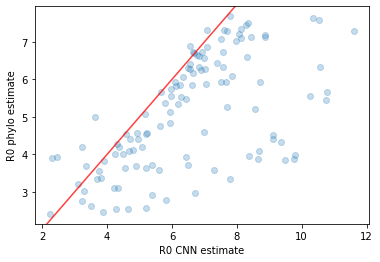

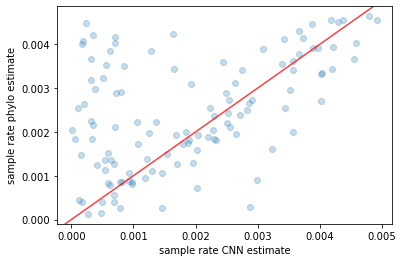

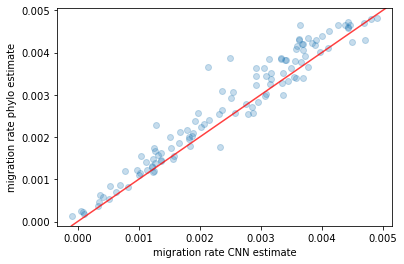

In [163]:
cn.plot_overlaid_scatter(misspec_tree_preds, misspec_tree_phylo,
                         misspec_tree_param_labels[:,5:8], 
                         param_names = ["R0", "sample rate", "migration rate"])

cn.plot_preds_labels((misspec_tree_preds), 
                     (misspec_tree_phylo), 
                     param_names = ["R0", "sample rate", "migration rate"], axis_labels = ['CNN estimate', 'phylo estimate'])

In [164]:
print("CNN R0: " , (np.median(misstree_pred_mape[:,0]-truetree_pred_mape[:,0])))
print("phylo R0: " , (np.median(misstree_phylo_mape[:,0]-truetree_phylo_mape[:,0])))

print("CNN sample rate: " , (np.median(misstree_pred_mape[:,1]-truetree_pred_mape[:,1])))
print("phylo sample rate: " , (np.median(misstree_phylo_mape[:,1]-truetree_phylo_mape[:,1])))

print("CNN m rate: " , (np.median(misstree_pred_mape[:,2]-truetree_pred_mape[:,2])))
print("phylo m rate: " , (np.median(misstree_phylo_mape[:,2]-truetree_phylo_mape[:,2])))



CNN R0:  2.693315666857417
phylo R0:  1.3421088567044985
CNN sample rate:  1.6737246481328467
phylo sample rate:  4.817481580229918
CNN m rate:  2.0638194513006134
phylo m rate:  0.9403763079008058


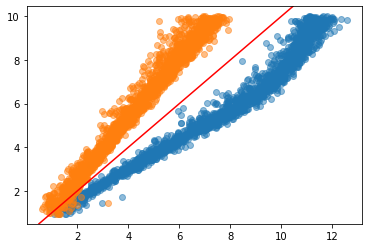

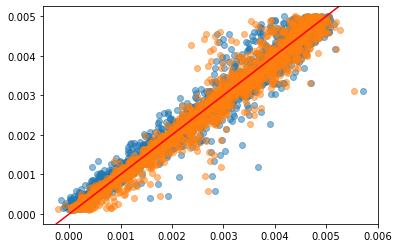

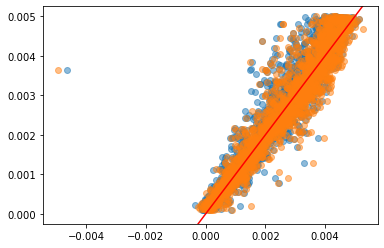

In [165]:
#################
## error in mu ##
#################
# create input tensors
# test_treeLocation_tensor, test_prior_tensor

mu_lower_error_phylocomp_prior_tensor = test_prior_tensor.copy()
mu_upper_error_phylocomp_prior_tensor = test_prior_tensor.copy()
mu_lower_error_phylocomp_prior_tensor[:,0,:] = 1/1.5 * test_prior_tensor[:,0,:]
mu_upper_error_phylocomp_prior_tensor[:,0,:] = 1.5 * test_prior_tensor[:,0,:]

mu_lower_error_phylocomp_normalized_preds = mymodel.predict([test_treeLocation_tensor, 
                                                             mu_lower_error_phylocomp_prior_tensor])
mu_upper_error_phylocomp_normalized_preds = mymodel.predict([test_treeLocation_tensor, 
                                                             mu_upper_error_phylocomp_prior_tensor])

mu_lower_error_phylocomp_preds = np.array([ np.add(np.multiply(mu_lower_error_phylocomp_normalized_preds[:,i-5], 
                                                               label_sd[i]), label_means[i]) for i in range(5,8)]).transpose()
mu_upper_error_phylocomp_preds = np.array([ np.add(np.multiply(mu_upper_error_phylocomp_normalized_preds[:,i-5], 
                                                               label_sd[i]), label_means[i]) for i in range(5,8)]).transpose()

# cn.plot_preds_labels(mu_lower_error_phylocomp_preds, denormalized_test_labels, 
#                      param_names = ["R0", "sample rate", "migration rate"])
# cn.plot_preds_labels(mu_upper_error_phylocomp_preds, denormalized_test_labels, 
#                      param_names = ["R0", "sample rate", "migration rate"])

plt.scatter(mu_lower_error_phylocomp_preds[:,0], denormalized_test_labels[:,0], alpha = 0.5)
plt.scatter(mu_upper_error_phylocomp_preds[:,0], denormalized_test_labels[:,0], alpha = 0.5)
plt.axline((2,2), slope = 1, color = "red")
plt.show()
plt.scatter(mu_lower_error_phylocomp_preds[:,1], denormalized_test_labels[:,1], alpha = 0.5)
plt.scatter(mu_upper_error_phylocomp_preds[:,1], denormalized_test_labels[:,1], alpha = 0.5)
plt.axline((0,0), slope = 1, color = "red")
plt.show()
plt.scatter(mu_lower_error_phylocomp_preds[:,2], denormalized_test_labels[:,2], alpha = 0.5)
plt.scatter(mu_upper_error_phylocomp_preds[:,2], denormalized_test_labels[:,2], alpha = 0.5)
plt.axline((0,0), slope = 1, color = "red")


In [166]:
mu_lower_error_phylocomp_prior_tensor.shape

(2000, 5, 2)

In [197]:
###############################
## analyze nadaeu 2021 trees ##
###############################
# read cblv data
full_tree_cblv = pd.read_csv("data_files/cblv_files/full_tree_nadeau2021.cblv.csv",
                             header = None, error_bad_lines = False).to_numpy()
A2_tree_cblv = pd.read_csv("data_files/cblv_files/A2_tree_nadeau2021.cblv.csv",
                    header = None, error_bad_lines = False).to_numpy()

In [198]:
# normalize and create tensors for full tree data and A2 clade data
# full tree
norm_full_tree_length = (96.36 - label_means[8])/label_sd[8]
norm_full_mean_branch_length = (12.68 - label_means[9])/label_sd[9]
norm_full_num_tips = (cn.get_num_tips(full_tree_cblv) - mean_num_tips) / sd_num_tips

full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(full_tree_cblv, 
                                                                       norm_full_tree_length,
                                                                       norm_full_mean_branch_length,
                                                                       norm_full_num_tips,
                                                                       normalize_tree_stats = False)
# A2 clade
norm_a2_tree_length = (54.57 - label_means[8])/label_sd[8]
norm_a2_mean_branch_length = (11.03 - label_means[9])/label_sd[9]
norm_a2_num_tips = (cn.get_num_tips(A2_tree_cblv) - mean_num_tips) / sd_num_tips

a2_treeLocation_tensor, a2_prior_tensor = cn.create_data_tensors(A2_tree_cblv, 
                                                                   norm_a2_tree_length,
                                                                   norm_a2_mean_branch_length,
                                                                   norm_a2_num_tips,
                                                                   normalize_tree_stats = False)

In [199]:
# make predictions
full_tree_normed_preds = mymodel.predict([full_treeLocation_tensor, full_prior_tensor])
a2_tree_normed_preds = mymodel.predict([a2_treeLocation_tensor, a2_prior_tensor])

full_tree_preds = np.array([ np.add(np.multiply(full_tree_normed_preds[:,i-5], 
                           label_sd[i]), label_means[i]) for i in range(5,8)]).transpose()

a2_tree_preds = np.array([ np.add(np.multiply(a2_tree_normed_preds[:,i-5], 
                           label_sd[i]), label_means[i]) for i in range(5,8)]).transpose()


print("full tree R0, sample rate, migration rate predictions")
print(full_tree_preds[0])

print("A2 clade R0, sample rate, migration rate predictions")
print(a2_tree_preds[0])


full tree R0, sample rate, migration rate predictions
[2.5798759e+00 1.7695643e-03 3.9816183e+02]
A2 clade R0, sample rate, migration rate predictions
[3.8960347e+00 1.6206086e-03 2.1412390e+02]


{'name': 'conv1d_1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(3, 7, 64)
0


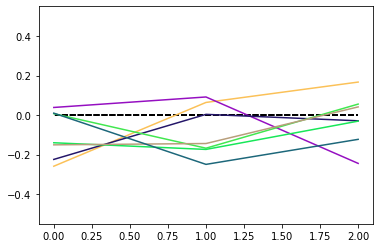

1


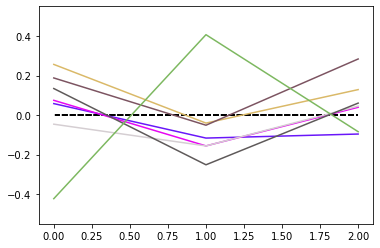

2


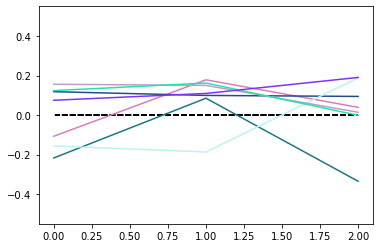

3


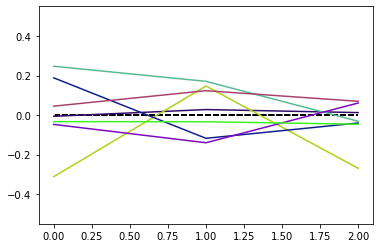

4


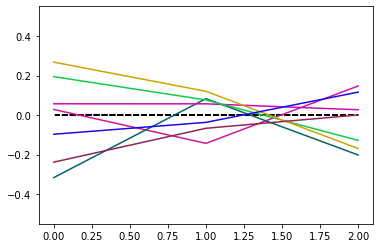

5


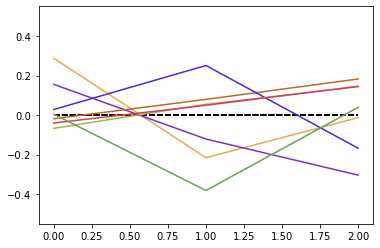

6


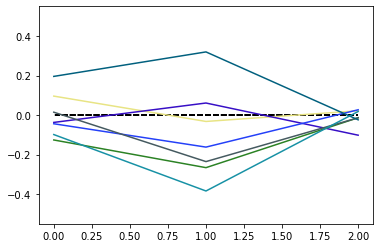

7


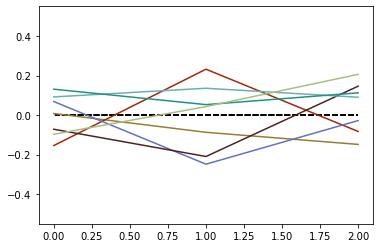

8


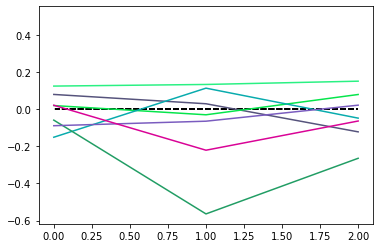

9


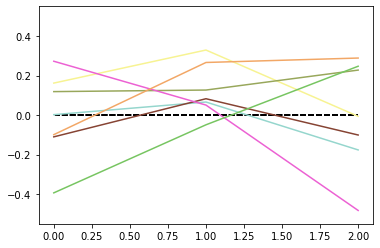

10


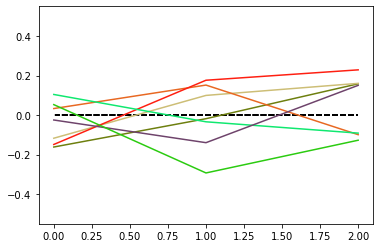

11


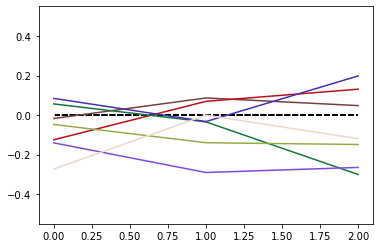

12


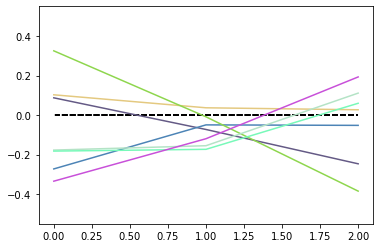

13


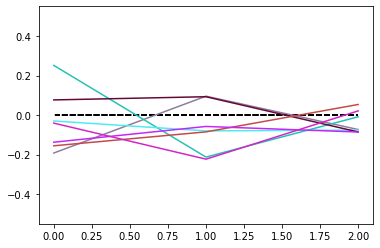

14


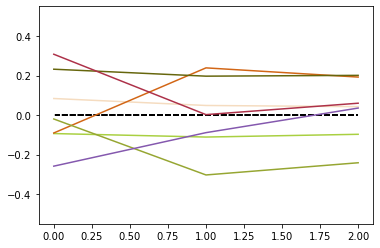

15


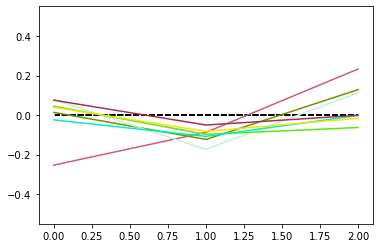

16


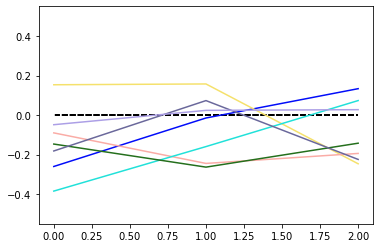

17


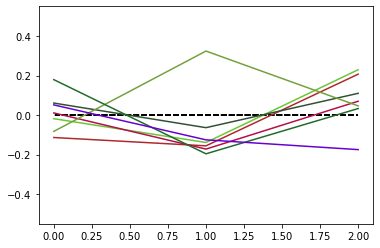

18


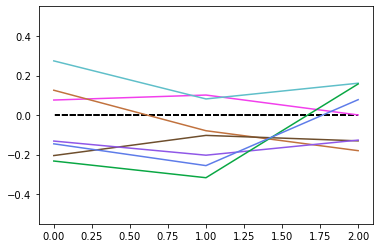

19


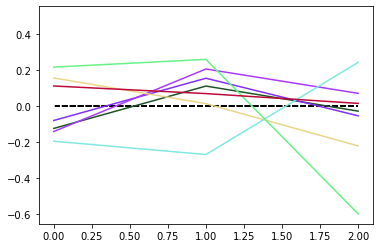

20


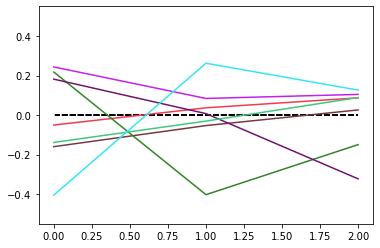

21


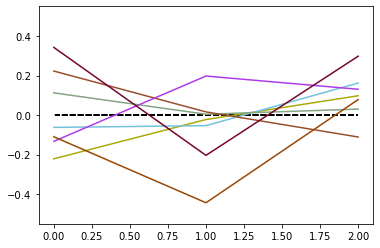

22


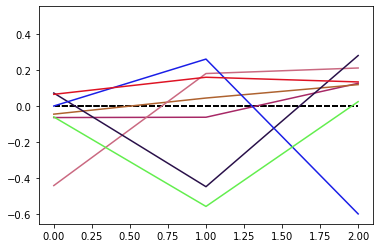

23


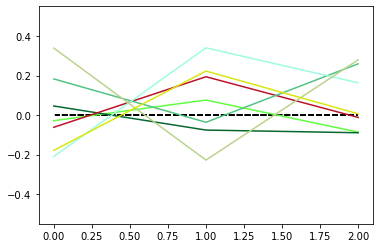

24


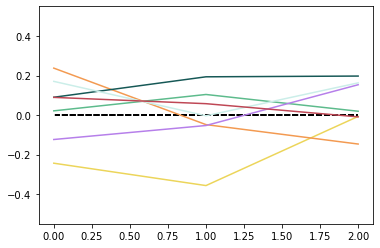

25


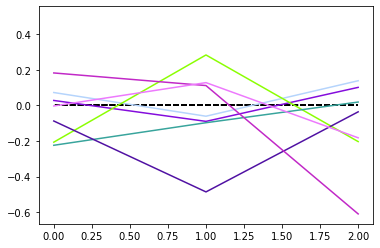

26


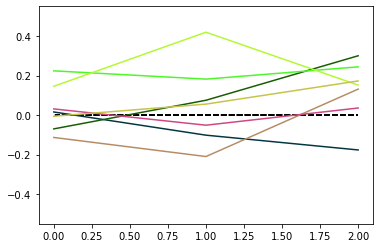

27


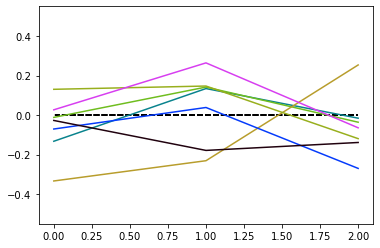

28


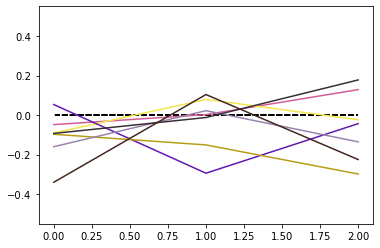

29


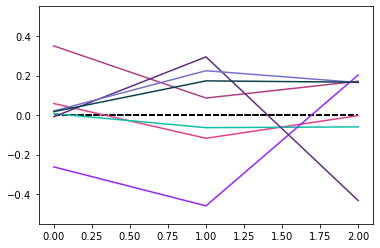

30


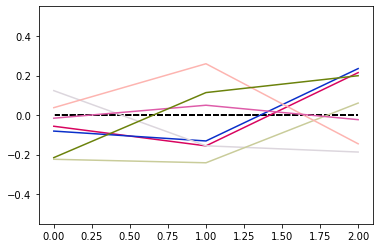

31


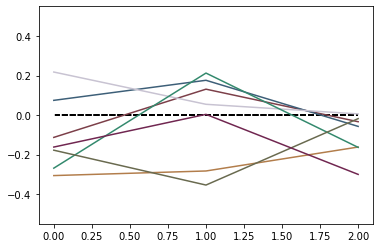

32


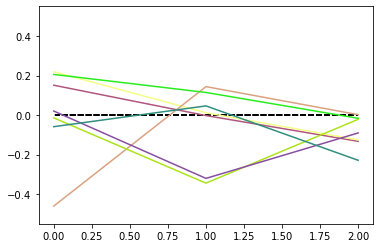

33


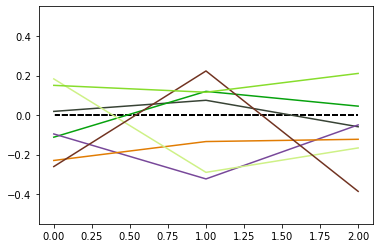

34


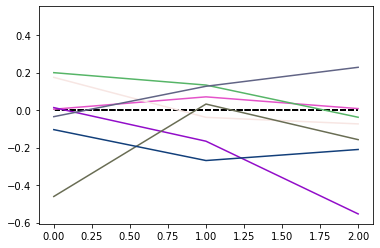

35


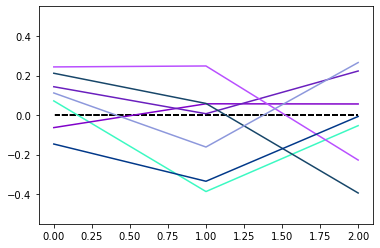

36


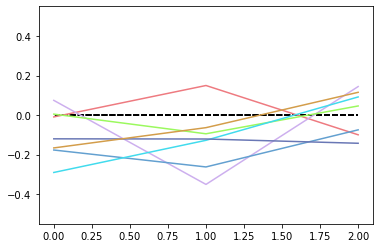

37


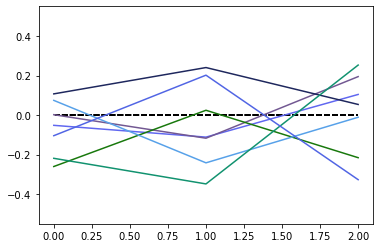

38


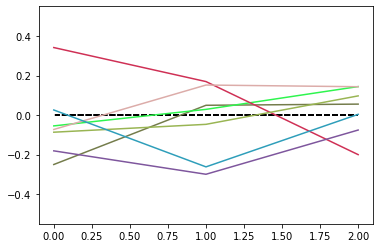

39


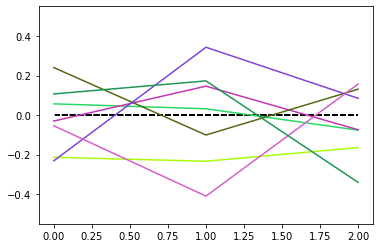

40


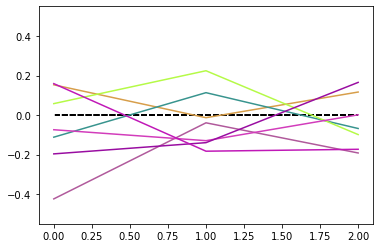

41


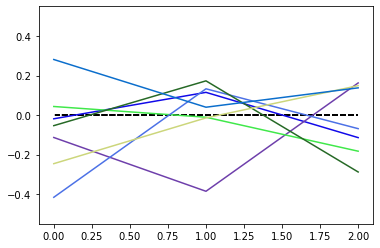

42


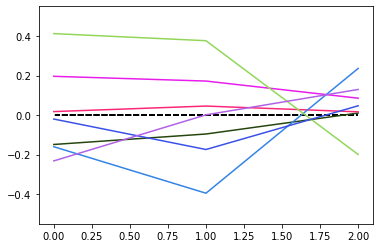

43


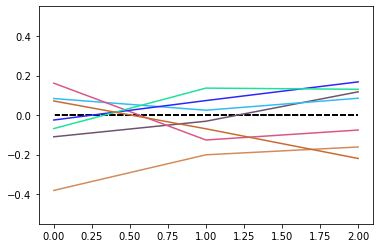

44


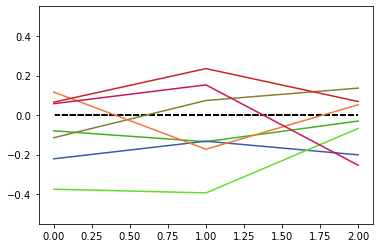

45


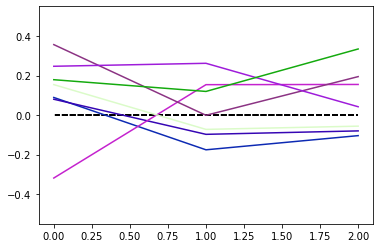

46


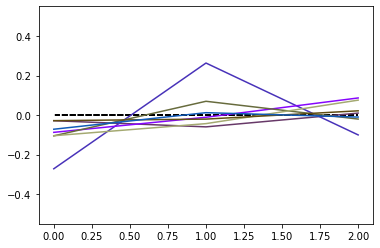

47


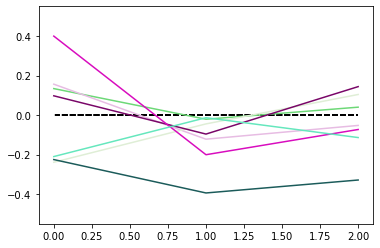

48


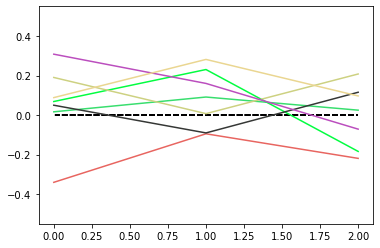

49


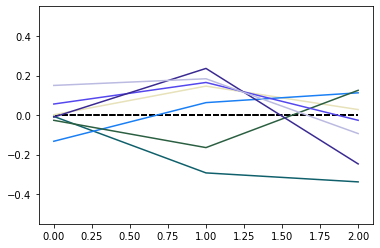

50


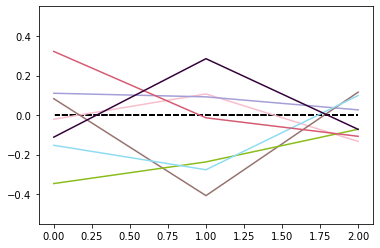

51


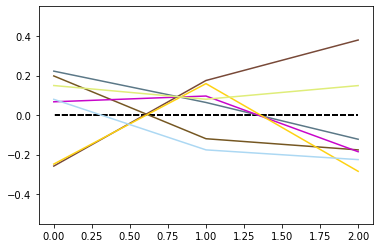

52


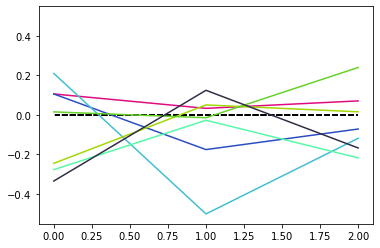

53


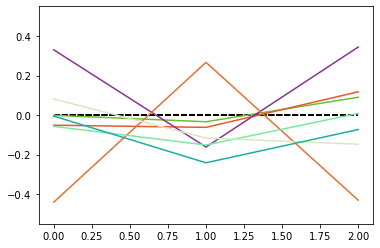

54


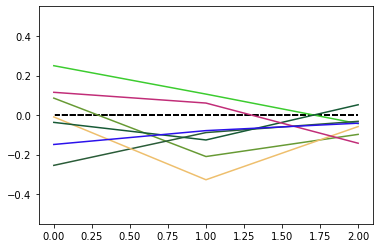

55


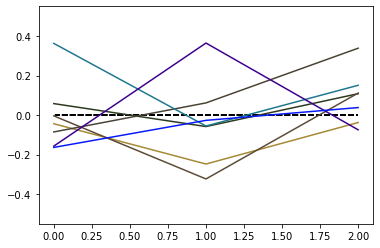

56


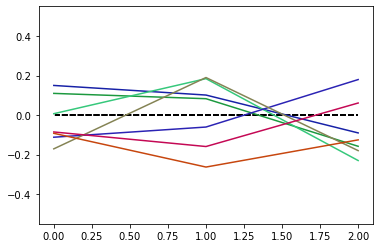

57


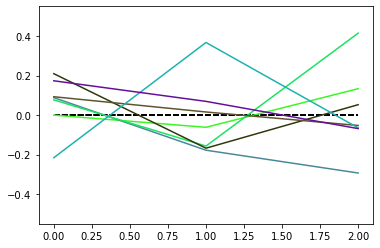

58


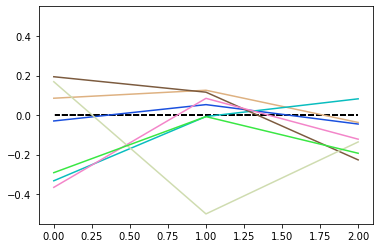

59


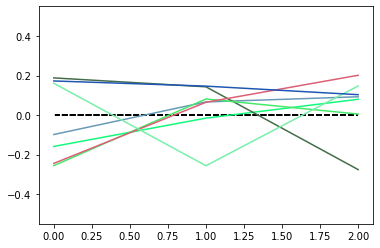

60


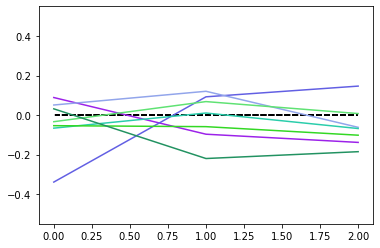

61


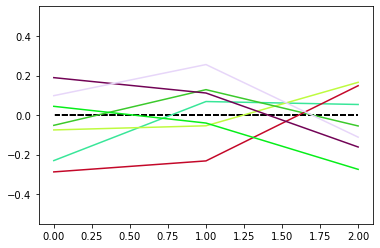

62


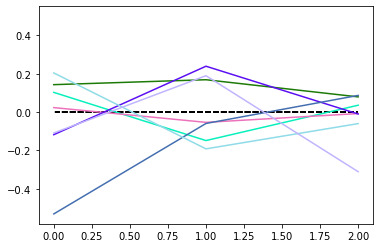

63


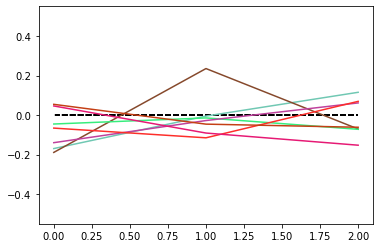

{'name': 'dense_2', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(128, 64)
0


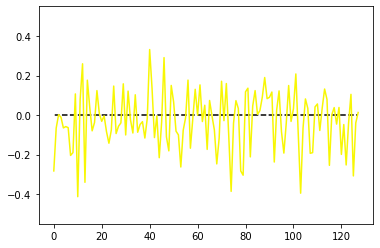

1


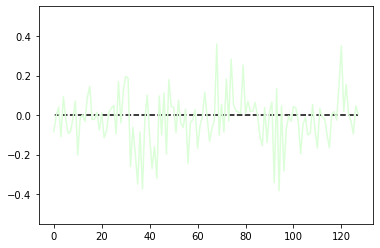

2


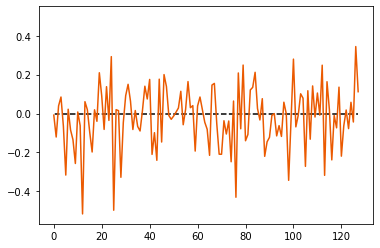

3


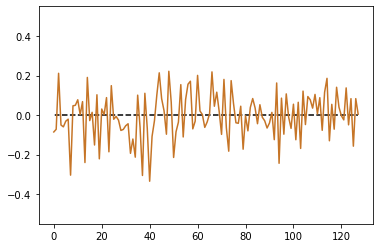

4


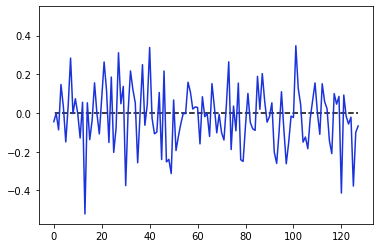

5


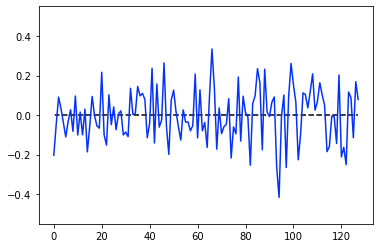

6


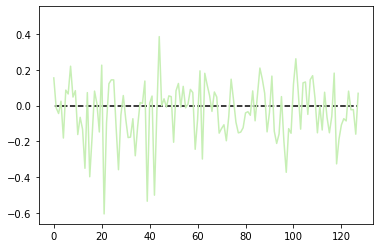

7


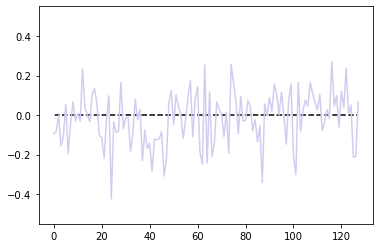

8


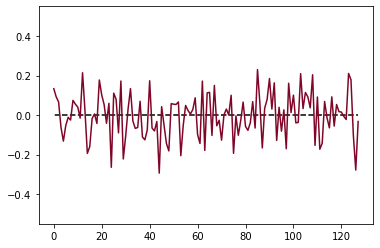

9


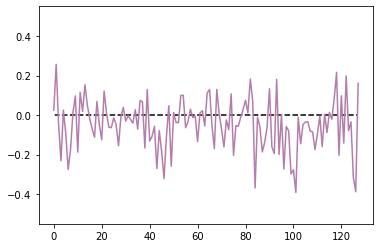

10


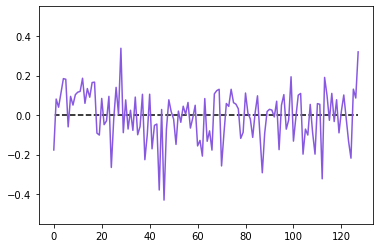

11


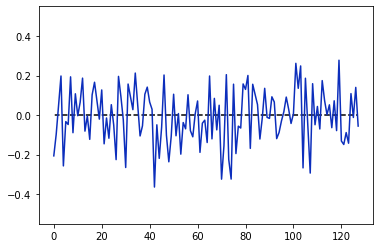

12


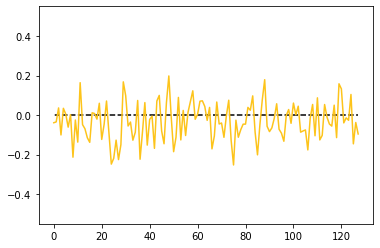

13


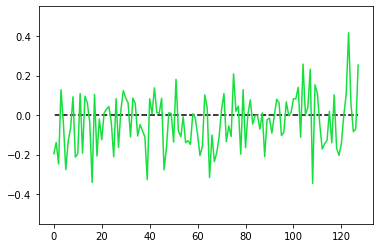

14


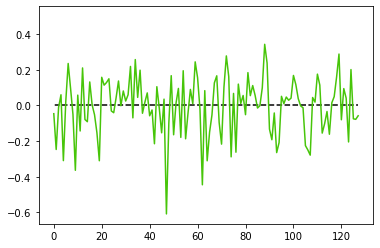

15


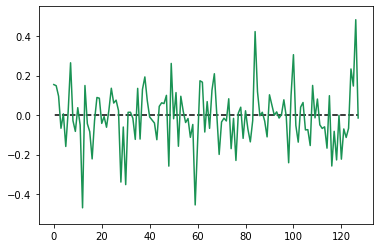

16


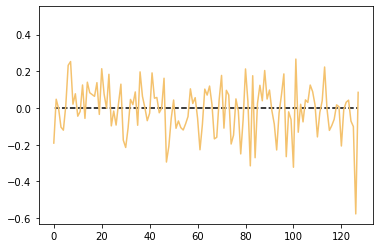

17


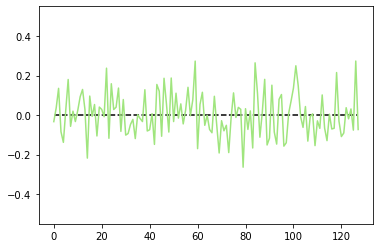

18


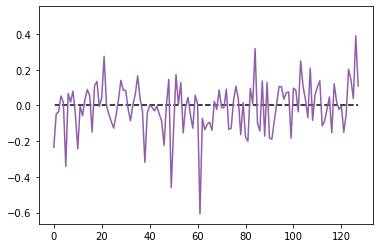

19


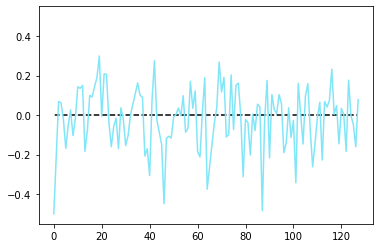

20


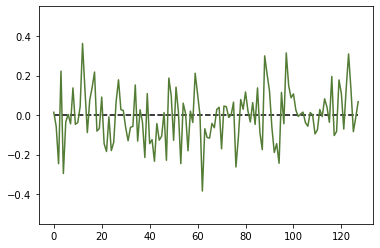

21


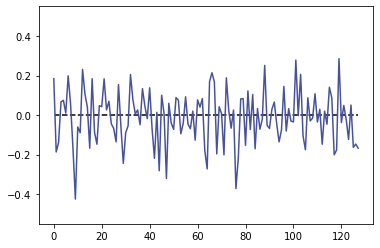

22


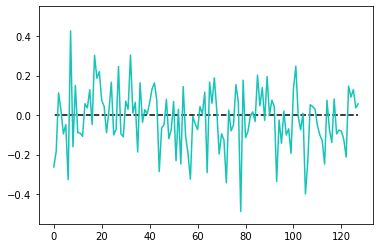

23


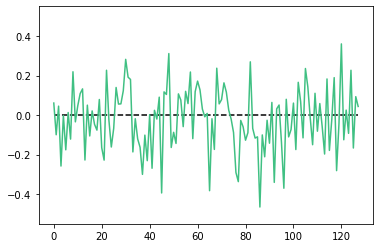

24


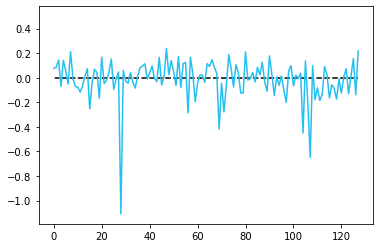

25


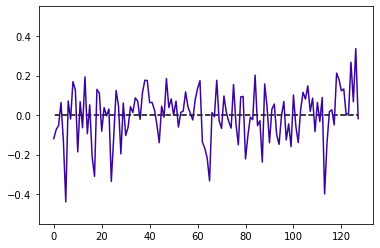

26


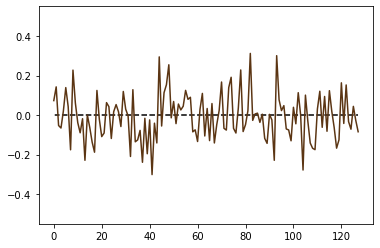

27


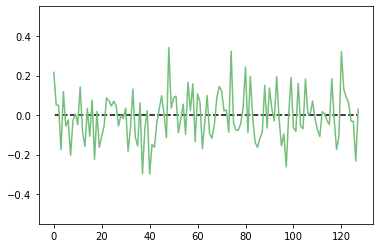

28


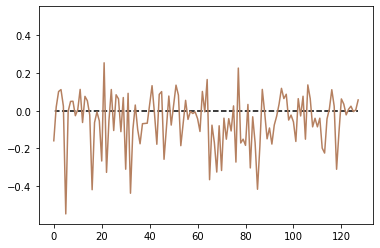

29


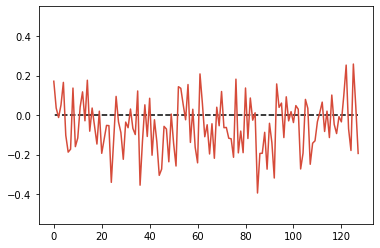

30


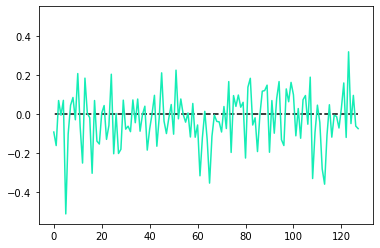

31


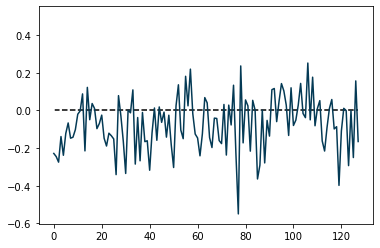

32


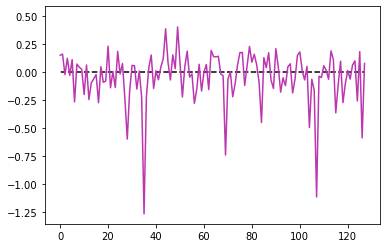

33


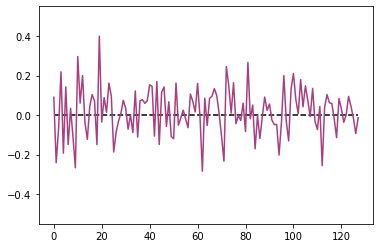

34


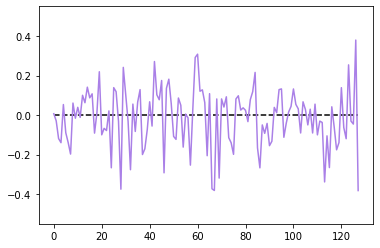

35


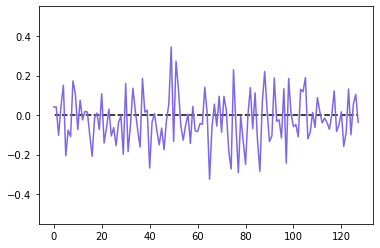

36


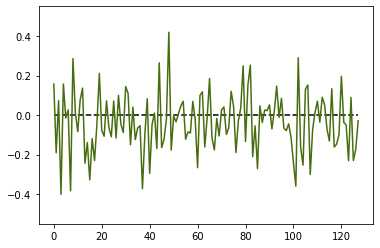

37


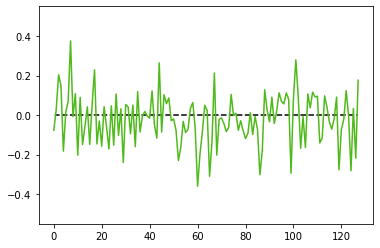

38


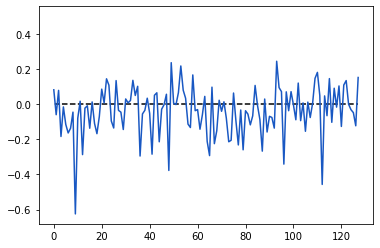

39


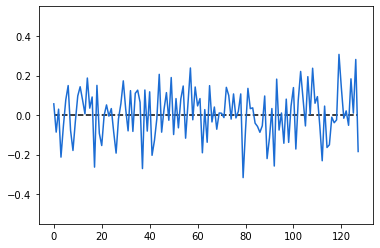

40


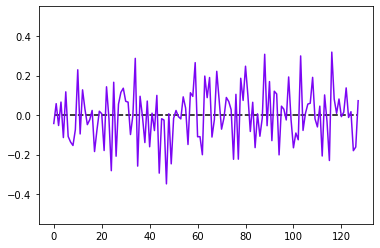

41


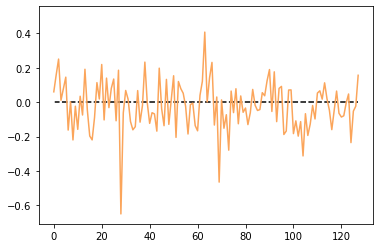

42


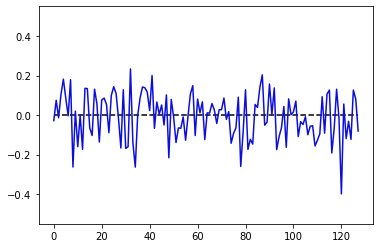

43


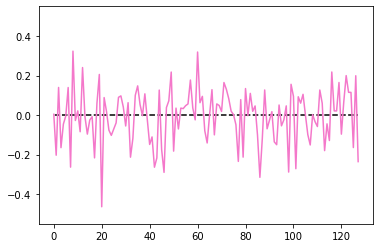

44


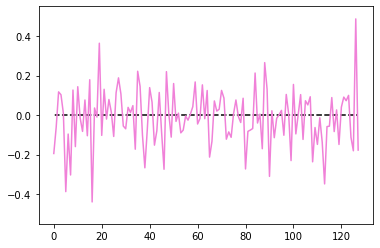

45


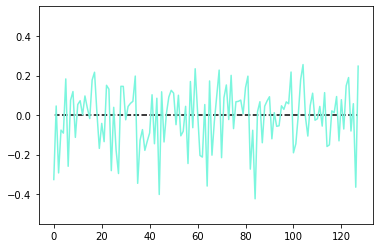

46


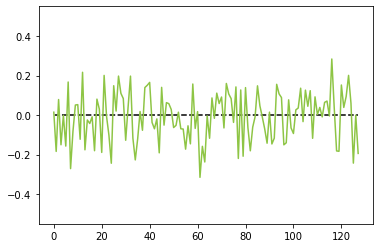

47


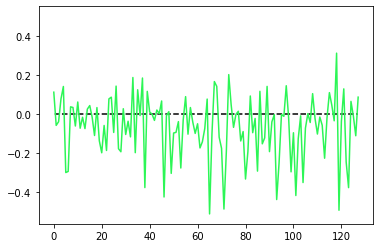

48


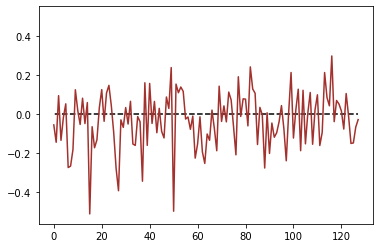

49


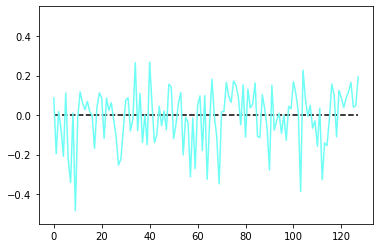

50


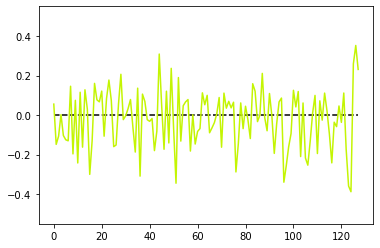

51


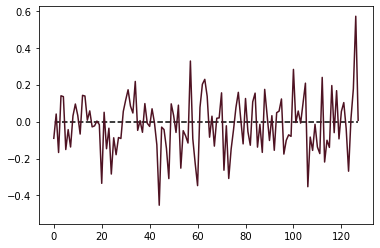

52


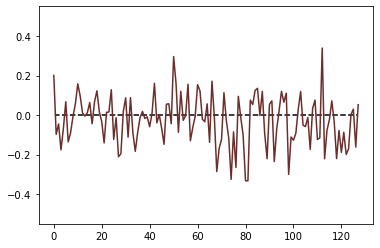

53


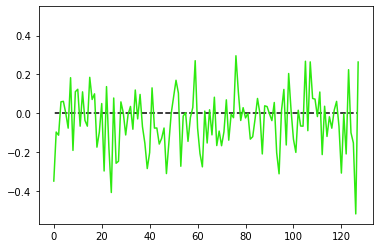

54


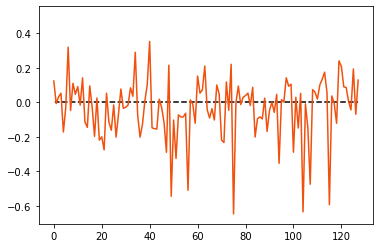

55


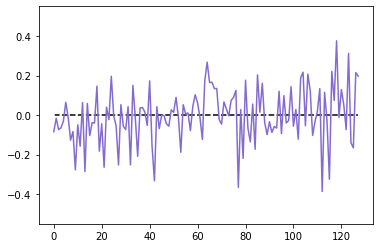

56


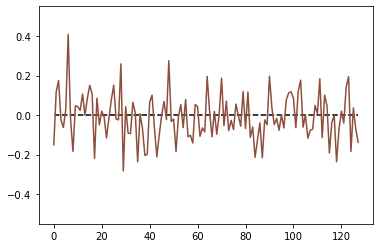

57


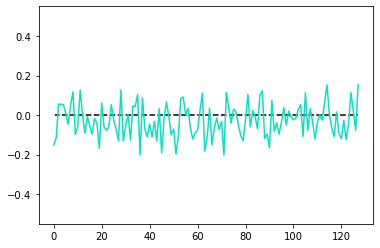

58


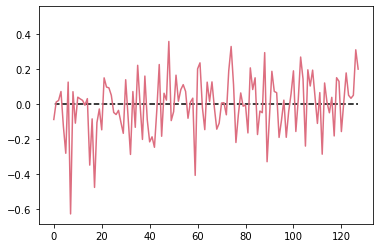

59


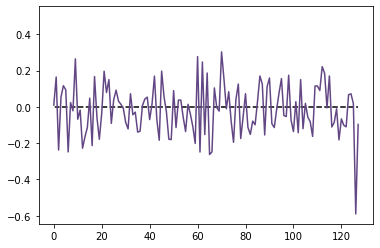

60


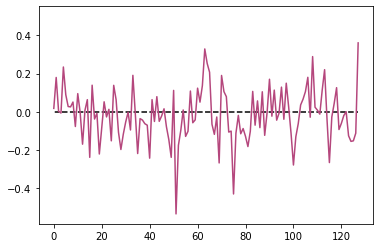

61


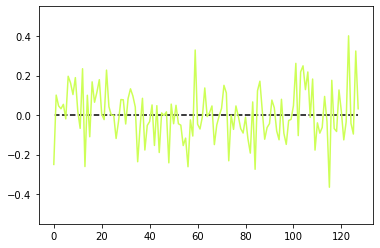

62


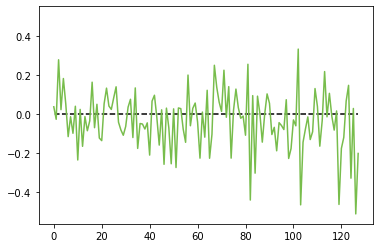

63


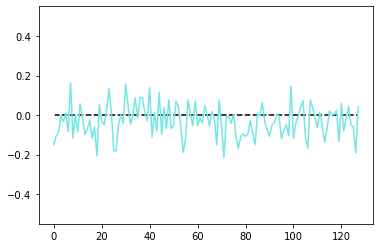

In [47]:
# visualize convolutional layer weights
mymodel.layers
cn.plot_convlayer_weights(mymodel, layer_num = 1)
cn.plot_denselayer_weights(mymodel, layer_num = -3)
